In [14]:
# My Google Drive Mount하기!
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
import numpy as np
import pandas as pd

FPath = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 12/jena_climate_2009_2016.csv'

df = pd.read_csv(FPath)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [16]:
print(df.shape)

(420551, 15)


In [17]:
# [Date Time] Column은 불필요하므로 삭제한다.
# df를 Numpy Array로 변환한다.
df = df.iloc[:, 1:].values

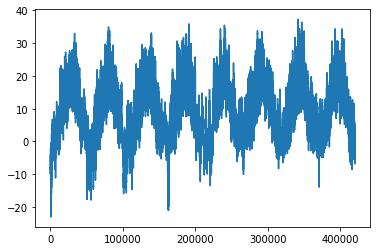

''

In [18]:
# degC에 대해 시각화하여 살펴본다.
# degC가 주기성을 가지고 있음을 확인 가능.
import matplotlib.pyplot as plt

data = df[:, 1]

plt.plot(range(len(data)), data)
plt.show()
;

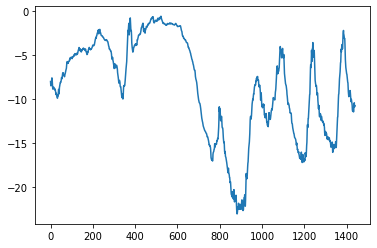

''

In [19]:
# degC에 대해 10일간 데이터에 한정해서 시각화하여 살펴본다.
data_10days = data[: 6 * 24 * 10]

plt.plot(range(len(data_10days)), data_10days)
plt.show()
;

# 데이터 준비

In [20]:
# 정규화 (앞의 200,000개를 Train Set으로 사용할 것이므로, 200,000개까지만 정규화를 해준다.)
df_mean = df[:200000].mean(axis=0)
df_std = df[:200000].std(axis=0)

df = (df - df_mean) / df_std

# Generator

* data_arr: 원본 데이터 (Array)
* lookback_cnt: 입력으로 사용하기 위해 거슬러 올라갈 timestep
* lookforward_cnt: Target으로 사용할 미래의 timestep
* min_index 및 max_index: 추출할 timestep의 범위를 지정하기 위한 data array의 index (validate set과 test set을 분리하기 위해 사용)
* shuffle: sample을 섞을지 시간 순서대로 추출할지 결정
* batch_size: batch의 sample 수
* step: data를 sampling할 timestep interval

In [30]:
def MakeGenerator(data_arr, lookback_cnt, lookforward_cnt, min_index, max_index, shuffle=False, batch_size=128, step_cnt=6):

    if max_index is None:
        max_index = len(data_arr) - lookforward_cnt - 1

    start_index = min_index + lookback_cnt

    while True:

        if shuffle==True:
            rows_arr = np.random.randint(
                low=start_index,
                high=max_index,
                size=batch_size
            )
        elif shuffle==False:
            if start_index + batch_size >= max_index:
                start_index = min_index + lookback_cnt
            rows_arr = np.arange(start_index, min(start_index + batch_size, max_index))
            start_index = start_index + len(rows_arr)

        input_arr = np.zeros((
            len(rows_arr),
            lookback_cnt // step_cnt,
            data_arr.shape[-1]
        ))
        target_arr = np.zeros((
            len(rows_arr),
        ))

        for idx, row in enumerate(rows_arr):
            idx_arr = range(rows_arr[idx] - lookback_cnt, rows_arr[idx], step_cnt)
            input_arr[idx] = data_arr[idx_arr]
            target_arr[idx] = data_arr[rows_arr[idx] + lookforward_cnt][1]

        yield input_arr, target_arr

In [31]:
LOOKBACK = 6 * 24 * 10 # - 10 days
STEP = 6 # every hour
LOOKFORWARD = 6 * 24 # + 1 day
BATCH_SIZE = 128

train_gen = MakeGenerator(
    data_arr=df,
    lookback_cnt=LOOKBACK,
    lookforward_cnt=LOOKFORWARD,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step_cnt=STEP,
    batch_size=BATCH_SIZE
)

val_gen = MakeGenerator(
    data_arr=df,
    lookback_cnt=LOOKBACK,
    lookforward_cnt=LOOKFORWARD,
    min_index=200001,
    max_index=300000,
    step_cnt=STEP,
    batch_size=BATCH_SIZE
)

test_gen = MakeGenerator(
    data_arr=df,
    lookback_cnt=LOOKBACK,
    lookforward_cnt=LOOKFORWARD,
    min_index=300001,
    max_index=None,
    step_cnt=STEP,
    batch_size=BATCH_SIZE
)

# 전체 Validate Set을 순회하기 위해 val_gen에서 추출할 횟수
CycleVal_cnt = (300000 - 200001 - LOOKBACK) // BATCH_SIZE

# 전체 Test Set을 순회하기 위해 test_gen에서 추출할 횟수
CycleTest_cnt = (len(df) - 300001 - LOOKBACK) // BATCH_SIZE

# Modeling

## 1. 24시간 뒤에 온도가 동일하다면?

In [32]:
BatchMAE_list = []

for iCycle in range(CycleVal_cnt):
    input_arr, target_arr = next(val_gen)
    pred_arr = input_arr[:, -1, 1]
    mae = np.mean(np.abs(pred_arr - target_arr))
    BatchMAE_list.append(mae)

print(np.mean(BatchMAE_list))
print(np.mean(BatchMAE_list) * df_std[1]) # 정규화하기 전의 값 (Celsius Degree로 차이를 파악할 수 있다.)

0.28973597299054815
2.564887434980494


## 2. Dense Layers 사용해보기

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Flatten(
    input_shape=(LOOKBACK // STEP, df.shape[-1])
))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=CycleVal_cnt
)

Epoch 1/20
500/500 [==============================] - 14s 23ms/step - loss: 1.4451 - val_loss: 0.8012
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.4682 - val_loss: 0.3833
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3043 - val_loss: 0.3011
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2720 - val_loss: 0.3125
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2573 - val_loss: 0.3054
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2487 - val_loss: 0.3077
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2400 - val_loss: 0.3574
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2333 - val_loss: 0.3159
Epoch 9/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2289 - val_loss: 0.3711
Epoch 10/20
500/500 [==============================] - 12s 24ms/step - loss: 0.225

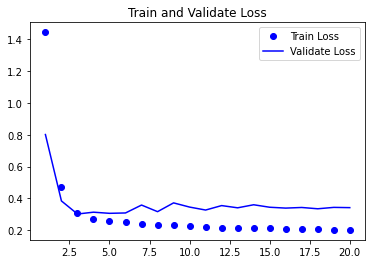

''

In [34]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = range(1, len(train_loss) + 1)

plt.figure()

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')

plt.title('Train and Validate Loss')
plt.legend()

plt.show()
;

## 3. GRU 사용해보기

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(GRU(
    32, input_shape=(None, df.shape[-1])
))
model.add(Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=CycleVal_cnt
)

Epoch 1/20
500/500 [==============================] - 21s 32ms/step - loss: 0.3087 - val_loss: 0.2778
Epoch 2/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2833 - val_loss: 0.2645
Epoch 3/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2796 - val_loss: 0.2644
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2719 - val_loss: 0.2662
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2690 - val_loss: 0.2691
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2644 - val_loss: 0.2636
Epoch 7/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2593 - val_loss: 0.2692
Epoch 8/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2565 - val_loss: 0.2715
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2502 - val_loss: 0.2757
Epoch 10/20
500/500 [==============================] - 16s 31ms/step - loss: 0.246

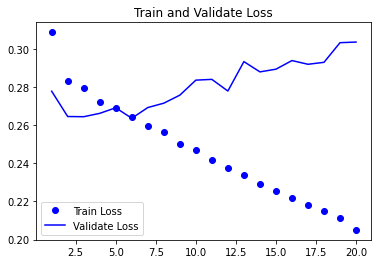

''

In [36]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = range(1, len(train_loss) + 1)

plt.figure()

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')

plt.title('Train and Validate Loss')
plt.legend()

plt.show()
;

## 4. 순환 Dropout 사용해보기

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(LSTM(
    32,
    dropout=0.2,
    input_shape=(None, df.shape[-1])
))
model.add(Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=CycleVal_cnt
)

Epoch 1/20
500/500 [==============================] - 17s 32ms/step - loss: 0.3131 - val_loss: 0.2757
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2925 - val_loss: 0.2720
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2829 - val_loss: 0.2745
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2761 - val_loss: 0.2769
Epoch 5/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2682 - val_loss: 0.2851
Epoch 6/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2610 - val_loss: 0.2863
Epoch 7/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2577 - val_loss: 0.2863
Epoch 8/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2510 - val_loss: 0.2938
Epoch 9/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2468 - val_loss: 0.2993
Epoch 10/20
500/500 [==============================] - 14s 29ms/step - loss: 0.243

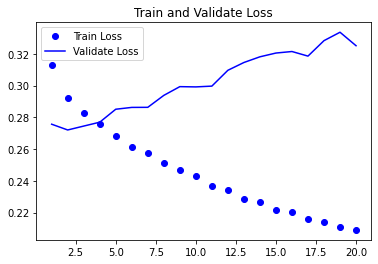

''

In [38]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = range(1, len(train_loss) + 1)

plt.figure()

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')

plt.title('Train and Validate Loss')
plt.legend()

plt.show()
;

## 5. Stacking 순환 Layers 사용해보기

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(GRU(
    32,
    dropout=0.1,
    return_sequences=True,
    input_shape=(None, df.shape[-1])
))
model.add(GRU(
    64,
    dropout=0.1
))
model.add(Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=CycleVal_cnt
)

Epoch 1/20
500/500 [==============================] - 23s 41ms/step - loss: 0.3163 - val_loss: 0.2785
Epoch 2/20
500/500 [==============================] - 20s 41ms/step - loss: 0.2932 - val_loss: 0.2705
Epoch 3/20
500/500 [==============================] - 21s 43ms/step - loss: 0.2839 - val_loss: 0.2689
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2747 - val_loss: 0.2637
Epoch 5/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2656 - val_loss: 0.2710
Epoch 6/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2557 - val_loss: 0.2801
Epoch 7/20
500/500 [==============================] - 20s 41ms/step - loss: 0.2496 - val_loss: 0.2769
Epoch 8/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2389 - val_loss: 0.2771
Epoch 9/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2316 - val_loss: 0.2927
Epoch 10/20
500/500 [==============================] - 21s 41ms/step - loss: 0.222

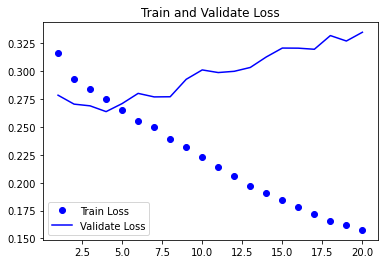

''

In [40]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = range(1, len(train_loss) + 1)

plt.figure()

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')

plt.title('Train and Validate Loss')
plt.legend()

plt.show()
;

## 6. 역방향 사용해보기

In [41]:
def MakeReverseGenerator(data_arr, lookback_cnt, lookforward_cnt, min_index, max_index, shuffle=False, batch_size=128, step_cnt=6):

    if max_index is None:
        max_index = len(data_arr) - lookforward_cnt - 1

    start_index = min_index + lookback_cnt

    while True:

        if shuffle==True:
            rows_arr = np.random.randint(
                low=start_index,
                high=max_index,
                size=batch_size
            )
        elif shuffle==False:
            if start_index + batch_size >= max_index:
                start_index = min_index + lookback_cnt
            rows_arr = np.arange(start_index, min(start_index + batch_size, max_index))
            start_index = start_index + len(rows_arr)

        input_arr = np.zeros((
            len(rows_arr),
            lookback_cnt // step_cnt,
            data_arr.shape[-1]
        ))
        target_arr = np.zeros((
            len(rows_arr),
        ))

        for idx, row in enumerate(rows_arr):
            idx_arr = range(rows_arr[idx] - lookback_cnt, rows_arr[idx], step_cnt)
            input_arr[idx] = data_arr[idx_arr]
            target_arr[idx] = data_arr[rows_arr[idx] + lookforward_cnt][1]

        yield input_arr[:, ::-1, :], target_arr

In [42]:
LOOKBACK = 6 * 24 * 10 # - 10 days
STEP = 6 # every hour
LOOKFORWARD = 6 * 24 # + 1 day
BATCH_SIZE = 128

train_revgen = MakeReverseGenerator(
    data_arr=df,
    lookback_cnt=LOOKBACK,
    lookforward_cnt=LOOKFORWARD,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step_cnt=STEP,
    batch_size=BATCH_SIZE
)

val_revgen = MakeReverseGenerator(
    data_arr=df,
    lookback_cnt=LOOKBACK,
    lookforward_cnt=LOOKFORWARD,
    min_index=200001,
    max_index=300000,
    step_cnt=STEP,
    batch_size=BATCH_SIZE
)

test_revgen = MakeReverseGenerator(
    data_arr=df,
    lookback_cnt=LOOKBACK,
    lookforward_cnt=LOOKFORWARD,
    min_index=300001,
    max_index=None,
    step_cnt=STEP,
    batch_size=BATCH_SIZE
)

In [43]:
model = Sequential()

model.add(GRU(
    32,
    input_shape=(None, df.shape[-1])
))
model.add(Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit(
    train_revgen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_revgen,
    validation_steps=CycleVal_cnt
)

Epoch 1/20
500/500 [==============================] - 16s 30ms/step - loss: 0.4747 - val_loss: 0.4719
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.4395 - val_loss: 0.4613
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3898 - val_loss: 0.4317
Epoch 4/20
500/500 [==============================] - 14s 29ms/step - loss: 0.3539 - val_loss: 0.3867
Epoch 5/20
500/500 [==============================] - 14s 29ms/step - loss: 0.3121 - val_loss: 0.3316
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2868 - val_loss: 0.3246
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2726 - val_loss: 0.3257
Epoch 8/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2645 - val_loss: 0.3303
Epoch 9/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2591 - val_loss: 0.3360
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.253

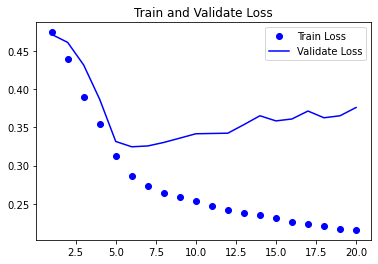

''

In [44]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = range(1, len(train_loss) + 1)

plt.figure()

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')

plt.title('Train and Validate Loss')
plt.legend()

plt.show()
;

### 역방향을 Text Data에 적용해본다면?

In [46]:
from tensorflow.keras.datasets import imdb

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM

MaxFeatures = 10000
MaxLen = 100

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=MaxFeatures)

train_input = pad_sequences(train_input, maxlen=MaxLen)
test_input = pad_sequences(test_input, maxlen=MaxLen)

model = Sequential()

model.add(Embedding(MaxFeatures + 1, 128))
model.add(LSTM(32, go_backwards=True)) # 역방향으로 LSTM 적용
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_input,
    train_target,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Epoch 1/10
157/157 [==============================] - 5s 20ms/step - loss: 0.5031 - acc: 0.7407 - val_loss: 0.4328 - val_acc: 0.8340
Epoch 2/10
157/157 [==============================] - 3s 17ms/step - loss: 0.3142 - acc: 0.8744 - val_loss: 0.3950 - val_acc: 0.8166
Epoch 3/10
157/157 [==============================] - 3s 16ms/step - loss: 0.2574 - acc: 0.9001 - val_loss: 0.3551 - val_acc: 0.8464
Epoch 4/10
157/157 [==============================] - 3s 16ms/step - loss: 0.2185 - acc: 0.9182 - val_loss: 0.4579 - val_acc: 0.8510
Epoch 5/10
157/157 [==============================] - 3s 16ms/step - loss: 0.1919 - acc: 0.9293 - val_loss: 0.5370 - val_acc: 0.8284
Epoch 6/10
157/157 [==============================] - 3s 17ms/step - loss: 0.1673 - acc: 0.9378 - val_loss: 0.4184 - val_acc: 0.8334
Epoch 7/10
157/157 [==============================] - 3s 16ms/step - loss: 0.1544 - acc: 0.9428 - val_loss: 0.4331 - val_acc: 0.8346
Epoch 8/10
157/157 [==============================] - 3s 16ms/step - 

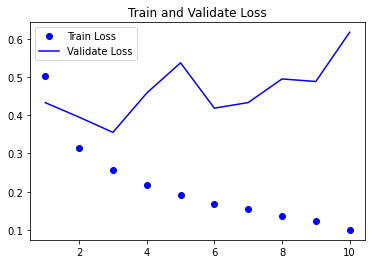

''

In [47]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = range(1, len(train_loss) + 1)

plt.figure()

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')

plt.title('Train and Validate Loss')
plt.legend()

plt.show()
;

### 양방향을 Text Data에 적용해본다면?

In [48]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional

model = Sequential()

model.add(Embedding(MaxFeatures + 1, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_input,
    train_target,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/10
157/157 [==============================] - 6s 20ms/step - loss: 0.5210 - acc: 0.7391 - val_loss: 0.3773 - val_acc: 0.8396
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 0.3313 - acc: 0.8661 - val_loss: 0.3653 - val_acc: 0.8470
Epoch 3/10
157/157 [==============================] - 2s 15ms/step - loss: 0.2707 - acc: 0.8954 - val_loss: 0.3910 - val_acc: 0.8468
Epoch 4/10
157/157 [==============================] - 2s 16ms/step - loss: 0.2349 - acc: 0.9110 - val_loss: 0.3570 - val_acc: 0.8526
Epoch 5/10
157/157 [==============================] - 2s 16ms/step - loss: 0.2034 - acc: 0.9236 - val_loss: 0.3447 - val_acc: 0.8494
Epoch 6/10
157/157 [==============================] - 2s 16ms/step - loss: 0.1873 - acc: 0.9306 - val_loss: 0.3636 - val_acc: 0.8444
Epoch 7/10
157/157 [==============================] - 2s 15ms/step - loss: 0.1676 - acc: 0.9377 - val_loss: 0.4300 - val_acc: 0.8322
Epoch 8/10
157/157 [==============================] - 2s 16ms/step - 

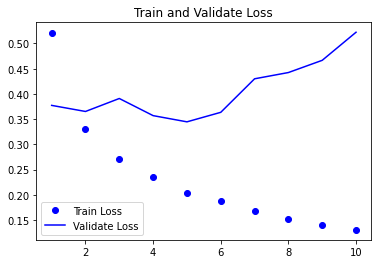

''

In [49]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = range(1, len(train_loss) + 1)

plt.figure()

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')

plt.title('Train and Validate Loss')
plt.legend()

plt.show()
;

## 7. 양방향 사용해보기

In [50]:
model = Sequential()

model.add(Bidirectional(GRU(32), input_shape=(None, df.shape[-1])))
model.add(Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=CycleVal_cnt
)

Epoch 1/20
500/500 [==============================] - 24s 42ms/step - loss: 0.3029 - val_loss: 0.2710
Epoch 2/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2739 - val_loss: 0.2673
Epoch 3/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2686 - val_loss: 0.2649
Epoch 4/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2631 - val_loss: 0.2729
Epoch 5/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2581 - val_loss: 0.2677
Epoch 6/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2515 - val_loss: 0.2678
Epoch 7/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2481 - val_loss: 0.2708
Epoch 8/20
500/500 [==============================] - 20s 39ms/step - loss: 0.2411 - val_loss: 0.2742
Epoch 9/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2339 - val_loss: 0.2795
Epoch 10/20
500/500 [==============================] - 20s 40ms/step - loss: 0.228

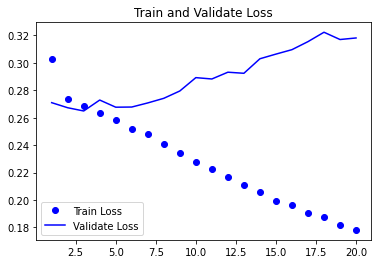

''

In [51]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = range(1, len(train_loss) + 1)

plt.figure()

plt.plot(epoch_list, train_loss, 'bo', label='Train Loss')
plt.plot(epoch_list, val_loss, 'b', label='Validate Loss')

plt.title('Train and Validate Loss')
plt.legend()

plt.show()
;

In [ ]:
# 참고

# return_state: True이 경우, 출력에 State를 함께 출력
# stateful: 각 sample의 마지막 state를 다음 batch 때 초기 state로 설정